# Analiza uczenia ze wzmocnieniem – środowisko MountainCarContinuous-v0 z algorytmem PPO

W niniejszym notebooku przeprowadzono eksperymenty uczenia ze wzmocnieniem w środowisku `MountainCarContinuous-v0` z wykorzystaniem algorytmu PPO (Proximal Policy Optimization). Celem było porównanie wpływu różnych zestawów hiperparametrów i architektur sieci na efektywność treningu.


In [1]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np
import matplotlib.pyplot as plt
import time


## Charakterystyka środowiska

Środowisko `MountainCarContinuous-v0` polega na sterowaniu samochodem poruszającym się po dolinie, tak aby zdobył wystarczającą prędkość i wspiął się na szczyt wzgórza. Akcja to wartość ciągła z zakresu [-1, 1] reprezentująca siłę napędową. Otrzymuje się nagrodę +100 za osiągnięcie celu, jednak środowisko penalizuje za długie próby, przyznając ujemne nagrody proporcjonalne do czasu.

Zadanie jest trudne, ponieważ wymaga planowania długoterminowego: samochód musi najpierw zjechać w dół, by nabrać impetu.

## Charakterystyka algorytmu PPO

Algorytm PPO (Proximal Policy Optimization) należy do grupy metod typu policy gradient i służy do optymalizacji polityki sterowania. Jego kluczową cechą jest zastosowanie ograniczonych, tzw. "bezpiecznych" aktualizacji parametrów poprzez mechanizm clipowania funkcji celu, co znacząco poprawia stabilność uczenia się w porównaniu do starszych metod, takich jak REINFORCE czy A2C. PPO sprawdza się dobrze zarówno w środowiskach z przestrzenią akcji ciągłych, jak i dyskretnych, co czyni go popularnym i efektywnym wyborem.


# Testowanie różnych zestawów hiperparametrów
Poniżej znajdują się 3 różne zestawy hiperparemtrów, które będziemy testować, aby ustalić które są najlepsze

In [ ]:
# --- Ustawienia ---
env_id = "MountainCarContinuous-v0"
total_timesteps = 50000
num_runs = 10
eval_interval = 5000
n_eval_episodes = 10

# Zestawy hiperparametrów
hyperparams = {
    "A": {"learning_rate": 1e-5, "clip_range": 0.2, "gamma": 0.99, "gae_lambda": 0.95, "n_steps": 512},
    "B": {"learning_rate": 1e-4, "clip_range": 0.2, "gamma": 0.99, "gae_lambda": 0.95, "n_steps": 1024},
    "C": {"learning_rate": 1e-3, "clip_range": 0.3, "gamma": 0.99, "gae_lambda": 0.95, "n_steps": 2048},
}


## Funkcja `train_and_evaluate`

* `DummyVecEnv` umożliwia obsługę środowisk wektorowych, które są wymagane przez bibliotekę Stable-Baselines3 do równoległego wykonywania i zarządzania środowiskami.
* `VecNormalize` automatycznie normalizuje zarówno obserwacje (`norm_obs=True`), jak i nagrody (`norm_reward=True`).

  * Normalizacja obserwacji sprawia, że dane wejściowe do sieci neuronowej mają stabilne rozkłady statystyczne (średnia bliska 0, odchylenie standardowe bliskie 1), co ułatwia proces uczenia.
  * Normalizacja nagród zapobiega problemom związanym z bardzo dużymi lub bardzo małymi wartościami nagród, poprawiając stabilność i szybkość uczenia się.
* W funkcji tworzymy instancję modelu PPO, który uczy się przez określoną liczbę kroków, regularnie oceniając swoją politykę i zbierając średnie nagrody.
* Na koniec symulujemy jeden epizod z wyuczoną polityką w trybie wizualizacji, aby zobaczyć efekt działania modelu.


In [5]:
def make_env(seed):
    def _init():
        env = gym.make(env_id)
        env.reset(seed=seed)
        env.action_space.seed(seed)
        return env
    return _init

def train_and_evaluate(params, seed):
    env = DummyVecEnv([make_env(seed)])
    env = VecNormalize(env, norm_obs=True, norm_reward=True)

    model = PPO("MlpPolicy", env, verbose=0,
                learning_rate=params["learning_rate"],
                clip_range=params["clip_range"],
                gamma=params["gamma"],
                gae_lambda=params["gae_lambda"],
                n_steps=params["n_steps"],
                seed=seed)

    rewards = []
    timesteps_so_far = 0
    while timesteps_so_far < total_timesteps:
        start_time = time.time()
        model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
        elapsed = time.time() - start_time
        # print(f"Learned {eval_interval} steps in {elapsed:.2f}s")
        timesteps_so_far += eval_interval

        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes, deterministic=True)
        rewards.append(mean_reward)

    # Symulacja 1 epizodu do wizualizacji
    obs = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _ = env.step(action)
        env.render()

    env.close()
    return rewards


Trening zestawu A...


/opt/anaconda3/envs/gym/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/opt/anaconda3/envs/gym/lib/python3.10/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Trening zestawu B...
Trening zestawu C...


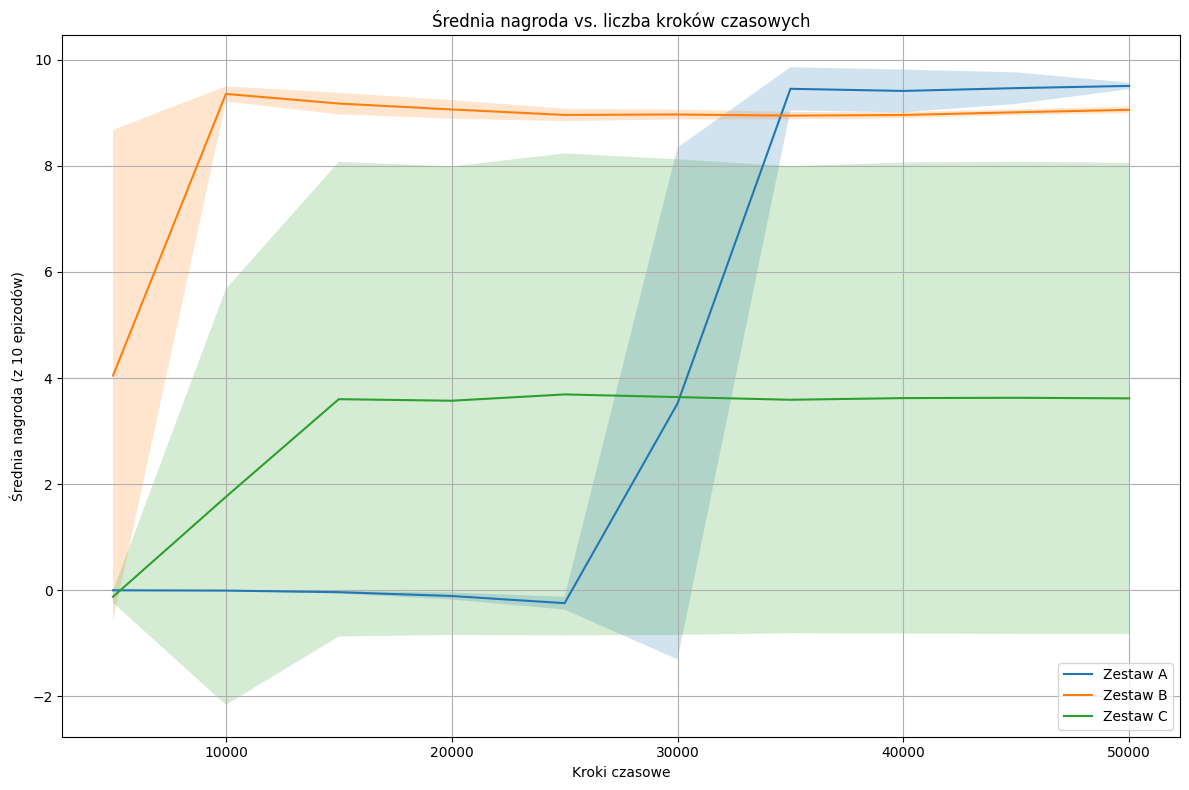

In [6]:
def main():
    results = {}
    steps = np.arange(eval_interval, total_timesteps + 1, eval_interval)

    for name, params in hyperparams.items():
        print(f"Trening zestawu {name}...")
        all_runs_rewards = []
        for run in range(num_runs):
            seed = 1000 + run
            rewards = train_and_evaluate(params, seed)
            all_runs_rewards.append(rewards)
            # print(f"Run {run+1}/{num_runs} done")

        all_runs_rewards = np.array(all_runs_rewards)
        mean_rewards = np.mean(all_runs_rewards, axis=0)
        std_rewards = np.std(all_runs_rewards, axis=0)

        results[name] = {"mean": mean_rewards, "std": std_rewards}

    plt.figure(figsize=(12, 8))
    for name in hyperparams:
        plt.plot(steps, results[name]["mean"], label=f"Zestaw {name}")
        plt.fill_between(steps,
                         results[name]["mean"] - results[name]["std"],
                         results[name]["mean"] + results[name]["std"],
                         alpha=0.2)
    plt.title("Średnia nagroda vs. liczba kroków czasowych")
    plt.xlabel("Kroki czasowe")
    plt.ylabel("Średnia nagroda (z 10 epizodów)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

main()


## Analiza wyników testowania różnych hiperparametrów 

W eksperymencie rozważono trzy zestawy hiperparametrów, różniące się głównie współczynnikiem uczenia (`learning_rate`), `n_steps` oraz zakresem `clip_range`.

Wyniki wskazują, że zestaw **B (learning_rate = 1e-4)** najszybciej uzyskiwał najlepsze wyniki średniej nagrody, osiągając wartości zbliżone do +90 w ostatnich krokach. Zestaw **A (1e-5)** uczył się zbyt wolno, ale osiągał końcowo bardzo dobre wyniki, natomiast **C (1e-3)** miał tendencję do niestabilnego zachowania, prawdopodobnie przez zbyt agresywną aktualizację.

Średni czas potrzebny na przetworzenie 5000 kroków to około 5-6 sekund, co daje ~0.0001 s na krok środowiska.

Wnioskiem jest, że dobór umiarkowanego learning rate i rozsądnego `n_steps` (512–1024) jest kluczowy dla skuteczności PPO w tym środowisku.


# Testowanie różnych architektur sieci używanych przez agenta

Zostały przetestowane dwie architektury sieci wykorzystywanych przez agenta PPO. W obu przypadkach na wejście sieci trafia dwuelementowy wektor `[pozycja, prędkość]`, a na wyjściu znajduje się wartość ciągła reprezentująca siłę napędu.







## Architekture ReLu
Ta architektura to klasyczna konfiguracja `[64, 64]` z funkcją aktywacji ReLU. Zapewnia wystarczającą głębokość przy umiarkowanej liczbie parametrów.

Wejście: [pozycja, prędkość]  →  (2 neurony)

    ┌─────────────┐
    │  FC (64)    │  ← ReLU
    └─────────────┘
          ↓
    ┌─────────────┐
    │  FC (64)    │  ← ReLU
    └─────────────┘
          ↓
     Wyjście: [akcja ciągła]

## Architektura Tanh  (głębsza)
Ta architektura to głębsza sieć `[128, 64, 32]` z funkcją aktywacji Tanh, która lepiej odwzorowuje niestacjonarne zależności przy mniejszych gradientach.

Wejście: [pozycja, prędkość]  →  (2 neurony)

    ┌─────────────┐
    │  FC (128)   │  ← Tanh
    └─────────────┘
          ↓
    ┌─────────────┐
    │  FC (64)    │  ← Tanh
    └─────────────┘
          ↓
    ┌─────────────┐
    │  FC (32)    │  ← Tanh
    └─────────────┘
          ↓
     Wyjście: [akcja ciągła]


In [9]:
from torch.nn import Tanh, ReLU

hyperparams = {
    "ReLu": {
        "learning_rate": 3e-4,
        "clip_range": 0.2,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "n_steps": 1024,
        "policy_kwargs": dict(activation_fn=ReLU, net_arch=[64, 64])
    },
    "Tanh": {
        "learning_rate": 3e-4,
        "clip_range": 0.2,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "n_steps": 1024,
        "policy_kwargs": dict(activation_fn=Tanh, net_arch=[128, 64, 32])
    }
}
def train_and_evaluate_with_kwargs(params, seed):
    env = DummyVecEnv([make_env(seed)])
    env = VecNormalize(env, norm_obs=True, norm_reward=True)

    model = PPO("MlpPolicy", env, verbose=0,
                learning_rate=params["learning_rate"],
                clip_range=params["clip_range"],
                gamma=params["gamma"],
                gae_lambda=params["gae_lambda"],
                n_steps=params["n_steps"],
                policy_kwargs=params["policy_kwargs"],
                seed=seed)

    rewards = []
    timesteps_so_far = 0
    while timesteps_so_far < total_timesteps:
        start_time = time.time()
        model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
        elapsed = time.time() - start_time
        # print(f"Learned {eval_interval} steps in {elapsed:.2f}s")
        timesteps_so_far += eval_interval

        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes, deterministic=True)
        rewards.append(mean_reward)

    # Symulacja 1 epizodu do wizualizacji
    obs = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _ = env.step(action)
        env.render()

    env.close()
    return rewards


Trening zestawu ReLu...
Trening zestawu Tanh...


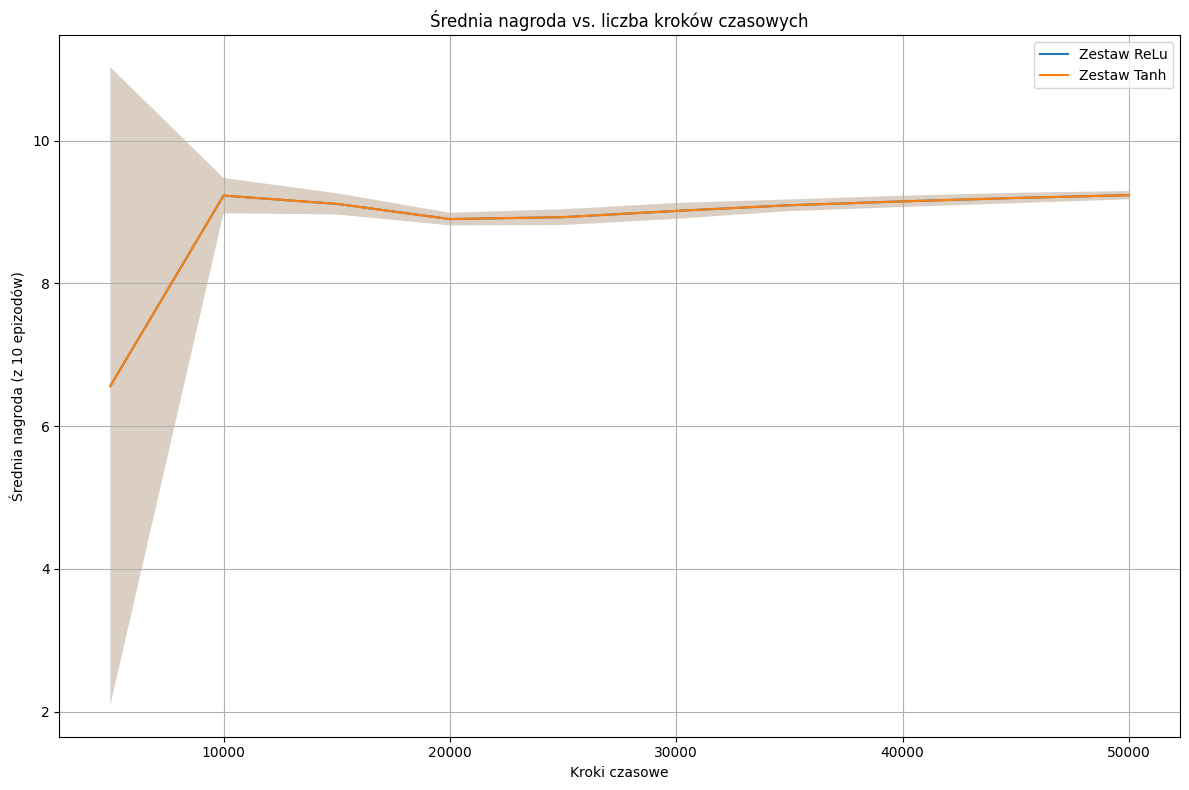

In [10]:
def main():
    results = {}
    steps = np.arange(eval_interval, total_timesteps + 1, eval_interval)

    for name, params in hyperparams.items():
        print(f"Trening zestawu {name}...")
        all_runs_rewards = []
        for run in range(num_runs):
            seed = 1000 + run
            rewards = train_and_evaluate(params, seed)
            all_runs_rewards.append(rewards)
            # print(f"Run {run+1}/{num_runs} done")

        all_runs_rewards = np.array(all_runs_rewards)
        mean_rewards = np.mean(all_runs_rewards, axis=0)
        std_rewards = np.std(all_runs_rewards, axis=0)

        results[name] = {"mean": mean_rewards, "std": std_rewards}

    plt.figure(figsize=(12, 8))
    for name in hyperparams:
        plt.plot(steps, results[name]["mean"], label=f"Zestaw {name}")
        plt.fill_between(steps,
                         results[name]["mean"] - results[name]["std"],
                         results[name]["mean"] + results[name]["std"],
                         alpha=0.2)
    plt.title("Średnia nagroda vs. liczba kroków czasowych")
    plt.xlabel("Kroki czasowe")
    plt.ylabel("Średnia nagroda (z 10 epizodów)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

main()


## Wyniki testów róznych architektur sieci
Wyniki eksperymentów pokazują, że architektura Tanh uczy się wolniej, ale osiąga bardziej stabilne wyniki w dłuższym czasie, prawdopodobnie dzięki większej ekspresji reprezentacji. Architektura Relu może szybciej osiągać lokalne optimum, ale ma tendencję do niestabilności.

# Testowanie modelu z wyłączoną eksploracją

Do tego testu wzięliśmy hiperparametry agenta B z pierwszych testów, jako że to on osiągał najlepsze wyniki. Na takim agencie puściliśmy symulację z wyłączoną eksploracją



In [ ]:
def train_and_evaluate_no_exploration(params, seed):
    env = DummyVecEnv([make_env(seed)])
    env = VecNormalize(env, norm_obs=True, norm_reward=True)
    
    model = PPO("MlpPolicy", env, verbose=0,
                learning_rate=params["learning_rate"],
                clip_range=params["clip_range"],
                gamma=params["gamma"],
                gae_lambda=params["gae_lambda"],
                n_steps=params["n_steps"],
                seed=seed)
    
    rewards = []
    timesteps_so_far = 0
    while timesteps_so_far < total_timesteps:
        model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
        timesteps_so_far += eval_interval

        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes, deterministic=True)
        rewards.append(mean_reward)
    
    # Save normalization and model
    env.save("vecnormalize.pkl")
    model.save("ppo_model")

    # Load env and model for deterministic simulation
    eval_env = DummyVecEnv([make_env(seed)])
    eval_env = VecNormalize.load("vecnormalize.pkl", eval_env)
    eval_env.training = False
    eval_env.norm_reward = False
    
    model = PPO.load("ppo_model", env=eval_env)

    obs = eval_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)  # deterministic=True disables exploration here
        obs, reward, done, _ = eval_env.step(action)
        eval_env.render()

    eval_env.close()
    return rewards


In [ ]:
total_timesteps = 100_000    # for example
eval_interval = 10_000       # evaluate every 10k steps
n_eval_episodes = 5          # number of episodes to evaluate

def main():
    params_B = {
        "learning_rate": 1e-4,
        "clip_range": 0.2,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "n_steps": 1024
    }
    seed = 42
    rewards = train_and_evaluate_no_exploration(params_B, seed)

    # Optionally: plot rewards here if matplotlib is available
    import matplotlib.pyplot as plt
    plt.plot(rewards)
    plt.xlabel("Evaluation iteration")
    plt.ylabel("Mean reward")
    plt.title("Training progress")
    plt.show()

if __name__ == "__main__":
    main()